<H1><b>&emsp;&emsp;&emsp;&emsp;&emsp;MOVIE RECOMMENDATIONS PROJECT</b></H1>
<br><p>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Submitted by-
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Aasma John (adj2141)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Ravleen Singh Virdi (rv2428)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Sanchya Sahay (ss5901)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Shaurya Jadeja (sjj2126)</p>
<br><br><br><br><br><br><br><br>





#Objective

The main objective of this project is to develop a production-quality hybrid movie recommendation system that can provide recommendation to any user with more than 6 rated movies. For this project, we are using a hybrid model consisting of an <b>ALS model</b>, which is Stage 1, and then <b>content-based algorithm,</b>  which is Stage 2 on Movie Lens Dataset. Because we are using a series hybrid, Stage 1 is measured through Recall metric and Stage 2 is evaluated through Precision metric. We have also used <b> Coverage, Novelty and Serendipity </b> to measure the performance of the model.

The model is finally tested against baseline models from Assignment 2 (average baseline mode, ALS model) to understand how well our new model performs.

The intention of the model is to provide the user more accurate recommendations that will improve the overall experience and keep the user wanting to come back, hence leading to increase in user retention and revenue.

##Importing the libraries

In [44]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pyspark
from pyspark import SparkContext, SQLContext

from pyspark.sql.functions import *
from pyspark.sql import functions as F

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.metrics import precision_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
data = pd.read_csv("ratings.csv")
data['timestamp'] =pd.to_datetime(data['timestamp'],unit='s').dt.year
movies = pd.read_csv('movies.csv')

##Datasampling
We are using the same data sampling technique that we used in our previous assignment.

In [4]:
def sampling(subset):
    ###### selecting users that have rated >149 movies and <554 movies based on percentiles to balance the skewness
    user_rtgs_cnt = (subset.groupby(['userId']).count()).iloc[:,0:1].reset_index().rename(columns={"movieId":"ratings_count"})
    quantile_user_1=user_rtgs_cnt.quantile([.20, .40, .60, .70, .80, .90, .95, .97, .99, 1], axis = 0).drop(["userId"],axis=1)
    # print(quantile_user_1)
    user_rtgs_cnt=user_rtgs_cnt[user_rtgs_cnt.ratings_count >= quantile_user_1.iloc[5,0]] #80th percentile
    user_rtgs_cnt=user_rtgs_cnt[user_rtgs_cnt.ratings_count < quantile_user_1.iloc[8,0]] #99th percentile
    
    subset = subset.merge(user_rtgs_cnt[['userId']],on="userId", how="inner")  


    
    ###### filtering movies and removing least rated and abnormally highly rated to balance skewness
    movie_count = (subset[["movieId","rating"]].groupby(['movieId']).count()).reset_index().rename(columns={"rating":"ratings_per_movie"})
    
    movie_count = movie_count[movie_count.ratings_per_movie >= 250].reset_index(drop=True)
    quantile_movie_1 = movie_count.quantile([0.1, .50, .75, .80, .85, .90, .95, .97, .99, 1], axis = 0).drop(["movieId"],axis=1)
    # print(quantile_movie_1)
    movie_count = movie_count[movie_count.ratings_per_movie < quantile_movie_1.iloc[5,0]].reset_index(drop=True) #90th percentile

    quantile_movie_1 = movie_count.quantile([0.1, .50, .75, .80, .85, .90, .95, .97, .99, 1], axis = 0).drop(["movieId"],axis=1)
    subset = subset.merge(movie_count[['movieId']],on="movieId", how="inner")  
    movie_count["popularity_category"] = np.where(movie_count.ratings_per_movie <= quantile_movie_1.iloc[6,0],"popular","very popular")

    sampled_ratings=pd.DataFrame()
    
    total_movies = 800
    for i in movie_count.popularity_category.unique():
        if i == "popular":
          sampled_ratings=sampled_ratings.append(movie_count[movie_count.popularity_category==i]. \
                                               sample(n=int(0.80*total_movies), random_state=10))
        else:
          sampled_ratings=sampled_ratings.append(movie_count[movie_count.popularity_category==i]. \
                                               sample(n=int(0.20*total_movies), random_state=10))
  
        
    sampled_ratings.reset_index(drop=True, inplace=True)
    
    # Select user rows for only those movies which have been sampled
    subset = subset.merge(sampled_ratings[['movieId']],on="movieId", how="inner")
    

    ###### checking user engagement here. Taking users who have rated >70 movies
    user_rtgs_cnt_2=(subset.groupby(['userId']).count()).iloc[:,0:1].reset_index().rename(columns={"movieId":"rating_freq"})
    quantile_user_2=user_rtgs_cnt_2.quantile([.10, .20, .30, .40, .50, .75, .80, .85, .90, .95, 1], axis = 0).drop(["userId"],axis=1)
    # print(quantile_user_2)
    user_rtgs_cnt_2 = user_rtgs_cnt_2[user_rtgs_cnt_2.rating_freq>quantile_user_2.iloc[9,0]] #95th percentile  
    subset = subset.merge(user_rtgs_cnt_2[['userId']],on="userId", how="inner")
    
    ######
    # convert to train and test set: keep same no of users in both train n test, sample their movies rated based on 80/20 in train/test
    df_train = subset.groupby(['userId']).apply(lambda x : x.sample(frac=0.7,random_state=10)).reset_index(drop=True)
    z = subset.merge(df_train,how='outer', on=['userId','movieId','rating','timestamp'], indicator=True)
    df_test = z.query('_merge != "both"')
    df_test = df_test.drop(['_merge'],axis=1)
    df_test.reset_index(drop=True, inplace=True)
    
    
    return subset, df_train, df_test

df, df_train, df_test = sampling(data)




**Let's create a results dataset that stores evaluation metrics for all models used here:**

In [32]:
models = [ ('Baseline','0') ,
             ('Baseline_ALS','0'),
             ('Hybrid','0')  ]
results = pd.DataFrame(models, columns = ['Model','Precision_Score']) 

#Baseline Model 

##1) Baseline model (from Assignment 2)

*   This model predicts the rating for ith user for jth item, by using the average of average rating for jth item and ith user. We have shown the accuracy of this baseline model on our test data set by predicting the rating for each user-item pair in the test data set.

In [33]:
#Baseline model 
def base_model(df_train, df_test, results):
    avg_movie_rtg = (df_train[["movieId","rating"]].groupby(['movieId']).\
                     mean()).reset_index().rename(columns={"rating":"movie_average"})
    avg_user_rtg = (df_train[["userId","rating"]].groupby(['userId']).\
                     mean()).reset_index().rename(columns={"rating":"user_average"})
    df_test_baseline = df_test.merge(avg_movie_rtg,how='inner',on='movieId')
    df_test_baseline = df_test_baseline.merge(avg_user_rtg,how='inner',on='userId')
    df_test_baseline['predictions'] = (df_test_baseline['movie_average'] + df_test_baseline['user_average'])/2
    df_test_baseline["relevant_actual"]= np.where(df_test_baseline['rating']>=3.5, 1, 0)
    df_test_baseline["relevant_prediction"]= np.where(df_test_baseline['predictions']>=3.5, 1, 0)
    precision = precision_score(df_test_baseline["relevant_actual"], df_test_baseline["relevant_prediction"])
    
    results['Precision_Score'].iloc[0] = precision
    return precision

base_model(df_train, df_test, results)

,Model,Precision_Score
0,Baseline,0.846974
1,Baseline_ALS,0
2,Hybrid,0


##2) Collaborative Filtering Model (from Assignment 2) - ALS

#ALS/Matrix factorization method
Matrix Factorization is a technique to discover the latent factors from the ratings matrix and to map the items and the users against those factors. Consider a ratings matrix R with ratings by n users for m items. The ratings matrix R will have n×m rows and columns. The matrix R can be decomposed into two thin matrices P and Q. P will have n×f dimensions and Q will have m×f dimensions where f is the number of latent factors. In the figure below, there are two latent factors. The matrix R can be decomposed in such a way that the dot product of the matrix P and transposed Q will yield a matrix with n×m dimensions that closely approximates the original ratings matrix R.

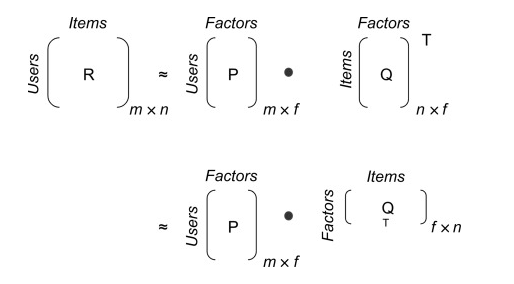

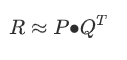

In [ ]:
#1 ALS
def train_als_model(train_set):
  #Initializing ALS with user, movie and ratings column
  model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative=True, coldStartStrategy="drop")
  
  #Creating a grid of parameters to search over through ParamGridBuilder
  param_grid = ParamGridBuilder().addGrid(model.rank, [25, 50, 75, 100]).addGrid(model.regParam, [0.01, 0.1, 0.25, 0.5]).build()
  
  #Evaluating criteria for selecting the best set of hyperparameters
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  
  #Trying all combinations of hyperparameters and determining best model using evaluator
  hyper_para = CrossValidator(estimator = model, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds= 5)
  
  #Choosing the best set of hyperparameters from cross validation
  final_model = hyper_para.fit(train_set)
  
  return final_model


def predict_als_model(model, test_set):
  predict = model.bestModel.transform(test_set)
  
  # Capped the predictions that exceed 5 to the max rating 5
  predict = predict.withColumn('prediction', when(col('prediction') > 5, 5).otherwise(col('prediction')))
  predict = predict.withColumn('prediction', when(col('prediction') <1, 1).otherwise(col('prediction')))
  predict = predict.select("*").toPandas()
  predict["relevant_actual"]= np.where(predict['rating']>=3.5, 1, 0)
  predict["relevant_prediction"]= np.where(predict['prediction']>=3.5, 1, 0)
  precision = precision_score(predict["relevant_actual"], predict["relevant_prediction"])
  
  return precision, predict



def als_baseline_precision_func(train_set, test_set, results):

  sc = SparkContext()
  sqlContext = SQLContext(sc)
  ratings_training_sc = sqlContext.createDataFrame(train_set)
  ratings_test_sc = sqlContext.createDataFrame(test_set)
  ratings_test_sc = ratings_test_sc.select(['userId', 'movieId', 'rating', 'timestamp'])

  model = train_als_model(ratings_training_sc)
  als_baseline_precision_, predictions_als_test_ = predict_als_model(model, ratings_test_sc)
  results['Precision_Score'].iloc[1] = als_baseline_precision_

  return predictions_als_test_, model

predictions_als_test, model = als_baseline_precision_func(df_train, df_test, results)


##Hyperparameter Tuning

To obtain the best results, we trained models with different combinations of rank adn regParam values. The RMSE values obtained fron these trfained models with different hyperparameters will further give us an indication of how our model performances and if there is a need to further tune the parameters. The best fit model obtained from this part would then be used for predictions and recommendations.

In [ ]:
params = [{k.name: v for k, v in i.items()} for i in model.getEstimatorParamMaps()]
result = pd.DataFrame.from_dict([{model.getEvaluator().getMetricName(): metric, **i} for i, metric in zip(params, model.avgMetrics)])
# result

##RMSE 

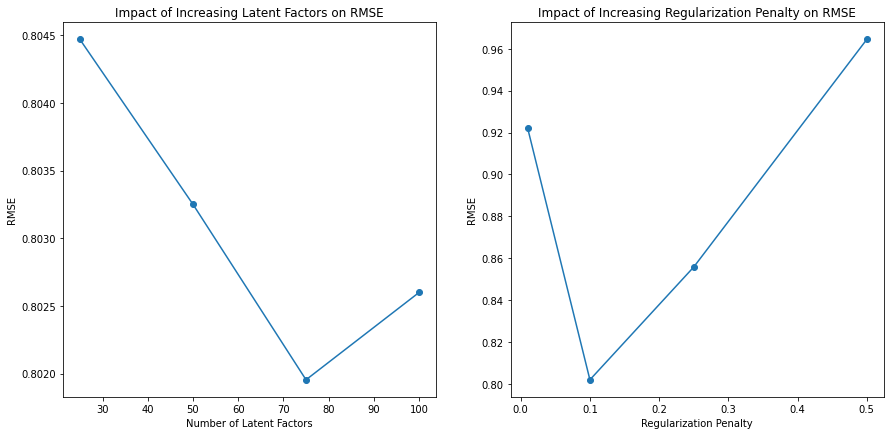

In [63]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)
plt.subplot(1, 2, 1)
plt.plot(result['rank'].unique(), result.groupby(['rank']).min()['rmse'], marker = 'o')
plt.title('Impact of Increasing Latent Factors on RMSE')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(result['regParam'].unique(), result.groupby(['regParam']).min()['rmse'], marker = 'o')
plt.title('Impact of Increasing Regularization Penalty on RMSE')
plt.xlabel('Regularization Penalty')
plt.ylabel('RMSE')

plt.show()

#Hybrid Recommendation System

We are using a series hybrid model with 2 stages to create our final recommendation system.
In stage 1 of this model we have used ALS technique which is based on the previously explained ALS model.
Using the ALS prediction on the test data, we calculated the absolute error between predicted & actual ratings. For each user we sorted the movies based on the absolute error (ascending order) and predicted rating (descending order) to filter top 30 movies for each user.

In stage 2, we introduced genres of these movies and recommended similar movies to each user based on the genre of the movie they searched for. We used content-based algorithm and have leveraged the cosine-similarity scores between movies to recommend 10 most similar movies (with highest cosine similarity scores).

##Stage 1: ALS Model



In [40]:
def hybrid_model_step2(test_set, als_predictions = predictions_als_test):
  als_predictions['abs_error'] = (als_predictions['rating'] - als_predictions['prediction']).abs()
  als_predictions = als_predictions.sort_values(by = ['userId', 'rating', 'abs_error'], ascending=[True, False, True])
  p_small_ = als_predictions.groupby('userId').head(30).reset_index(drop=True)


  return p_small_



In [69]:
# p_small = hybrid_model_step2(model, df_test)

##Stage 2: Content-Based Algorithm
</br>Taking top 30 movies for each user based on predicted ratings and the absolute error from the actual rating


In [41]:
def user_recommendation_cb_model(user, df, title_search):
  df = df[df.userId == user].reset_index()
  
  df['genres'] = df['genres'].str.split('|')
  df['genres'] = df['genres'].fillna("").astype('str')
  
  tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
  tfidf_matrix = tf.fit_transform(df['genres'])
  tfidf_matrix.shape

  
  cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
  # print(cosine_sim.shape)

  titles = df['title']
  indices = pd.Series(df.index, index=titles)

  def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]
  
  return (genre_recommendations(title_search).head(10))

##FINAL RECOMMENDATION

In [55]:
def final_hybrid_recommendation(user, title_search,test_set,movies_df):
  p_small = hybrid_model_step2(test_set)
  content_df = p_small.merge(movies_df, how='left', on='movieId')
  user_recommendations = user_recommendation_cb_model(user, content_df, title_search)

  return p_small, user_recommendations


In [56]:
#Example run
p_small, user_recommendations = final_hybrid_recommendation(56, 'Lord of War (2005)', df_test, movies)
user_recommendations

20            In Bruges (2008)
14               Breach (2007)
23          Wild Things (1998)
4         Cross of Iron (1977)
12     Longest Day, The (1962)
22    National Treasure (2004)
3                  Kids (1995)
6           Frost/Nixon (2008)
8         Little Buddha (1993)
Name: title, dtype: object

In [57]:
##Precision function

def row(x,xdf,sim):
  titles = xdf['title']
  indices = pd.Series(xdf.index, index=titles)
  idx = indices[x['title']]
  sim_scores = list(enumerate(sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:10]
  list_ = []
  for score in sim_scores:
    if score[1] >= 0.25: #################### CAN CHANGE 0.1 IN FUTURE ###################
      list_.append(1)
    else: 
      list_.append(0)
  precision = np.sum(list_)/len(list_)
  movie_indices = [i[0] for i in sim_scores]
  
  return list(titles.iloc[movie_indices]), list_, precision.round(2)


##precision

def cb_model_precision(test_set, movies_df,results):
  p_small = hybrid_model_step2(test_set)
  whole_df = p_small.merge(movies_df, how='left', on='movieId')
  return_df = pd.DataFrame()
  all_users = whole_df.userId.unique()
  for user in all_users:
    user_df = whole_df[whole_df.userId == user].reset_index()
    user_df['genres'] = user_df['genres'].str.split('|')
    user_df['genres'] = user_df['genres'].fillna("").astype('str')

    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(user_df['genres'])
    
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    user_df['recommendations'], user_df['prec_list'], user_df['precision'] = zip(*user_df.apply(lambda x: row(x,user_df,cosine_sim), axis=1))
    
    return_df = return_df.append(user_df)
    precision = return_df['precision'].mean()
    results['Precision_Score'].iloc[2] = precision

  return return_df

The above function for Hybrid precision returns the below data frame which contains the recommendation for each user search, the precision list based on 0.25 cosine similarity threshold (which was a good option based on the distribution we tested and it can be changed in future when we add more data points), and the precision score for each user recommendation. The overall model precision score is calculated by taking an average of the all the precisions scores.

We tried reducing the threshold to 0.2 and 0.1 which increased precision score only because we categorize mpre movies as "similar" at lower thresholds. 

In [58]:
#precision
final = cb_model_precision(df_test, movies, results)
final

,index,userId,movieId,rating,timestamp,prediction,relevant_actual,relevant_prediction,abs_error,title,genres,recommendations,prec_list,precision
0,0,56,6957,5.0,2010,2.576570,1,0,2.423430,Bad Santa (2003),"['Comedy', 'Crime']","(Ocean's Eleven (a.k.a. Ocean's 11) (1960), In...","(1, 1, 1, 0, 0, 0, 0, 0, 0)",0.33
1,1,56,1274,4.5,2010,3.211203,1,0,1.288797,Akira (1988),"['Action', 'Adventure', 'Animation', 'Sci-Fi']","(Lilo & Stitch (2002), Dune (1984), Ben-Hur (1...","(1, 1, 1, 1, 1, 1, 1, 0, 0)",0.78
2,2,56,1287,4.5,2010,3.077835,1,0,1.422165,Ben-Hur (1959),"['Action', 'Adventure', 'Drama']","(National Treasure (2004), Akira (1988), Kids ...","(1, 1, 1, 1, 1, 0, 0, 0, 0)",0.56
3,3,56,175,4.0,2010,3.214040,1,0,0.785960,Kids (1995),['Drama'],"(Frost/Nixon (2008), Little Buddha (1993), Bre...","(1, 1, 1, 1, 1, 1, 1, 1, 0)",0.89
4,4,56,3339,4.0,2011,3.208372,1,0,0.791628,Cross of Iron (1977),['War'],"(Longest Day, The (1962), Lord of War (2005), ...","(1, 1, 0, 0, 0, 0, 0, 0, 0)",0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,38335,283095,53460,0.5,2015,1.781342,0,0,1.281342,Surf's Up (2007),"['Animation', 'Children', 'Comedy']","(Tangled (2010), Lilo & Stitch (2002), Scooby-...","(1, 1, 1, 0, 0, 0, 0, 0, 0)",0.33
26,38336,283095,5444,0.5,2015,1.806095,0,0,1.306095,Lilo & Stitch (2002),"['Adventure', 'Animation', 'Children', 'Sci-Fi']","(Surf's Up (2007), Appleseed (Appurushîdo) (20...","(1, 1, 1, 1, 0, 0, 0, 0, 0)",0.44
27,38337,283095,37729,0.5,2015,1.828037,0,0,1.328037,Corpse Bride (2005),"['Animation', 'Comedy', 'Fantasy', 'Musical', ...","(Tangled (2010), Walk the Line (2005), Bewitch...","(1, 1, 1, 1, 0, 0, 0, 0, 0)",0.44
28,38338,283095,81847,0.5,2015,1.885005,0,0,1.385005,Tangled (2010),"['Animation', 'Children', 'Comedy', 'Fantasy',...","(Corpse Bride (2005), Surf's Up (2007), Scooby...","(1, 1, 1, 1, 1, 1, 1, 0, 0)",0.78


#Model Performance
<br><br>**1) Results Table**</b>

The precision score for each model:

In [48]:
print(results)

          Model Precision_Score
0      Baseline        0.846974
1  Baseline_ALS         0.86693
2        Hybrid        0.562106


<br><br>1) User Coverage</b>
<br>
User Coverage is the fraction of users for which at least k items can be recommended well. We first define what is a good recommendation - for our project it is recommended movies with rating > 3.5 and we will look at k = 5 movies. So essentially look at how many users were recommended atleast 5 good movies in their top 10 recommendations.

In [83]:
def row2(x,df,user):
  list_ = x['recommendations']
  pred = []
  for item in list_:
    ans = df[(df['title'] == item) & (df['userId'] == user)]['prediction']
    # print(type(ans))
    pred.extend(list(ans))
  list_2 = []
  sum_ = 0

  if len([i for i in pred if i>3.5]) > 5:
    coverage_ = 1
  else:
    coverage_ = 0
  return coverage_

def hybrid_coverage(hybrid_return, df):
  df = df.merge(movies[['movieId','title']], how='left', on='movieId')
  hybrid_return_ = hybrid_return.drop(columns = ["genres", "prec_list", "precision"])

  ret_df = pd.DataFrame()
  all_users = hybrid_return_.userId.unique()
  i=0
  for user in all_users:
    i += 1
    print("running for user: ", i)
    user_df = hybrid_return_[hybrid_return_['userId'] == user].reset_index()
    user_df['coverage'] = user_df.apply(lambda x: row2(x,df, user), axis=1)
    ret_df = ret_df.append(user_df)
  
  coverage = ret_df['coverage'].mean()
  return coverage


In [85]:
coverage = hybrid_coverage(final, p_small)
print(coverage)

0.24580073030777255


<b>2) Novelty</b>
<br>
Novelty measures how new or unknown recommendations are to a user. An individual item's novelty can be calculated as the log of the popularity of the item. A user's overal novelty is then the sum of the novelty of all items. 
<br><br>Our function returns:         
*   avg_overall_novelty: the average amount of novelty over
*   avg_novelty: the average user's amount of novelty over their recommended items        

In [86]:
data_ = df.merge(movies[['movieId', 'title']], on = 'movieId')
movie_popularity = data_.groupby('title')['rating'].count().reset_index()
movie_popularity = movie_popularity.rename(columns={'rating':'counts'})
movie_popularity['popular'] = np.where(movie_popularity['counts'] > 200, 1, 0)

movie_popularity['popular']

0      1
1      1
2      1
3      0
4      0
      ..
795    1
796    0
797    0
798    1
799    1
Name: popular, Length: 800, dtype: int64

In [89]:
movie_popularity['counts'].median()


0.36625

In [60]:
movie_popularity[movie_popularity['title'] == 'Drugstore Cowboy (1989)']

,title,counts,popular
54,Drugstore Cowboy (1989),240,1


In [94]:
def row3(x,df,user):
  list_ = x['recommendations']
  pred = []
  for item in list_:
    # print(item)
    ans = df[(df['title'] == item)]['popular']
    # print(ans)
    pred.extend(list(ans))
  # print(pred)
  novelty = (pred.count(0)/len(pred))
  return pred , novelty

def hybrid_novelty(hybrid_return, df):
  data_ = df.merge(movies[['movieId', 'title']], on = 'movieId')
  movie_popularity = data_.groupby('title')['rating'].count().reset_index()
  movie_popularity = movie_popularity.rename(columns={'rating':'counts'})
  movie_popularity['popular'] = np.where(movie_popularity['counts'] > 200, 1, 0)
  # print(movie_popularity.head(20))
  hybrid_return_ = hybrid_return.drop(columns = ["genres", "prec_list", "precision"])

  ret_df = pd.DataFrame()
  all_users = hybrid_return_.userId.unique()
  for user in all_users:
    user_df = hybrid_return_[hybrid_return_['userId'] == user].reset_index()
    user_df['popular'], user_df['novelty']= zip(*user_df.apply(lambda x: row3(x,movie_popularity, user), axis=1))
    ret_df = ret_df.append(user_df)
  novelty = ret_df['novelty'].mean()
    # print(ret_df)
  
  return novelty

In [95]:
hybrid_novelty(final, df)

0.2603141482641678

<b>Table with all performance metrics for all model(s)</b>

In [96]:
results

,Model,Precision_Score
0,Baseline,0.846974
1,Baseline_ALS,0.86693
2,Hybrid,0.562106


#Conclusion

The above results table shows the precision scores for each model we have tried: average baseline, ALS baseline and Hybrid model. The results conclude that the ALSE model outperforms the other two models. Hence introducing content-based algorithm in the second stage of the hybrid model did not improve the performance of the ALS model. This could be explained through various reasons which have been included in out potential watchouts below.

Also looking at the coverage and novelty scores, the hybrid model could perform better as mentioned in potential watchouts.


#Potential Watchout


1.   Our model currently only takes into consideration popular movies meaning movies that have good user engagement

2.   We want to address the cold start problem so that we do not consider users who have less number of ratings. But how would the recommendation behave when there is a new user?

3.   If a user has an unpredictable activity then what would the recommendation 
system suggest?

4.   Based on the above problem, how to design a model that quickly adapts to the unpredictable activity or new user’s taste

5.   With increasing sparsity in the data, how do we make the computation efficient and effective?

6.   Our recommendation model doesn't provide recommendations for movies that are not currently present in the database



#Future Recommendations


1.   Try advanced data sampling tecniques to better fit the model. Eg: can incorporate relevant business rules like movie location, language, year of release etc.

2.   To improve content based model we can incorporate further information on movies such as their overview/summary, director, production company, language etc.

3.  After ALS model, we have used absolute error in the rating and the predicted rating itself to sort and select top 50 movies for each user. A better metodology can be implemented to further improve this selection process
